In [11]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

%matplotlib inline

### Load Data

In [6]:
images_path = Path("../data/pictures")

In [7]:
images = [cv2.imread(img) for img in images_path.iterdir()]
total_images = len(images)
total_images

311

### Load Model

- `coco.names`: names of classes from MS COCO dataset
- `yolov4.weights`: weights of YOLOv4 pretrained on MS COCO
- `yolov4.cfg`: config for YOLOv4

In [8]:
with open("yolov4/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
yolo = cv2.dnn.readNet("yolov4/yolov4.weights", "yolov4/yolov4.cfg")

### Process Image

Single image processing pipeline

In [9]:
def process_image(image, height, width, index):
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    yolo.setInput(blob)

    output_layers = yolo.getUnconnectedOutLayersNames()
    layer_outputs = yolo.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []

    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                
                x = int(center_x - w/2)
                y = int(center_y - h/2)
                
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    meta_data = {
        "classes": [],
        "confidences": []
    }

    colors = np.random.uniform(0, 255, size=(len(classes), 3))
    if len(indexes) > 0:
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = str(round(confidences[i], 2))
            color = colors[class_ids[i]]
            meta_data["classes"].append(label)
            meta_data["confidences"].append(confidence)

            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image, f"{label} {confidence}", (x, y-5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    cv2.imwrite(f"results/{index}.jpg", image)
    return meta_data

Process images

In [12]:
meta_data = {}
for ind, image in tqdm(
    enumerate(images), 
    total=total_images, 
    desc="Images processing"
):
    height, width = image.shape[:2]
    meta_data[ind + 1] = process_image(image, height, width, ind + 1)

Images processing: 100%|██████████| 311/311 [01:51<00:00,  2.78it/s]


### Analysis

#### Found Nothing

In [13]:
found_nothing_count = 0
for ind, data in meta_data.items():
    if len(data["classes"]) == 0:
        found_nothing_count += 1
print(f"Number of pictures, where nothing was found: {found_nothing_count}/{total_images}")

Number of pictures, where nothing was found: 151/311


Almost half of images YOLO didn't detect any of items. That's simply because the majority of images are clothes and there are only 5 classes in MS COCO that correspond to either clothes or accessories: `backpack`, `umbrella`, `handbag`, `tie`, `suitcase`. Therefore clothes like jackets, shirts, boots and etc will not be detected by YOLO.

#### Found People

In [29]:
people_detected_count = 0
images_with_people = []
for ind, data in meta_data.items():
    if "person" in data["classes"]:
        people_detected_count += 1
        images_with_people.append(ind)
print(f"Number of detected people: {people_detected_count}/{total_images}")

Number of detected people: 25/311


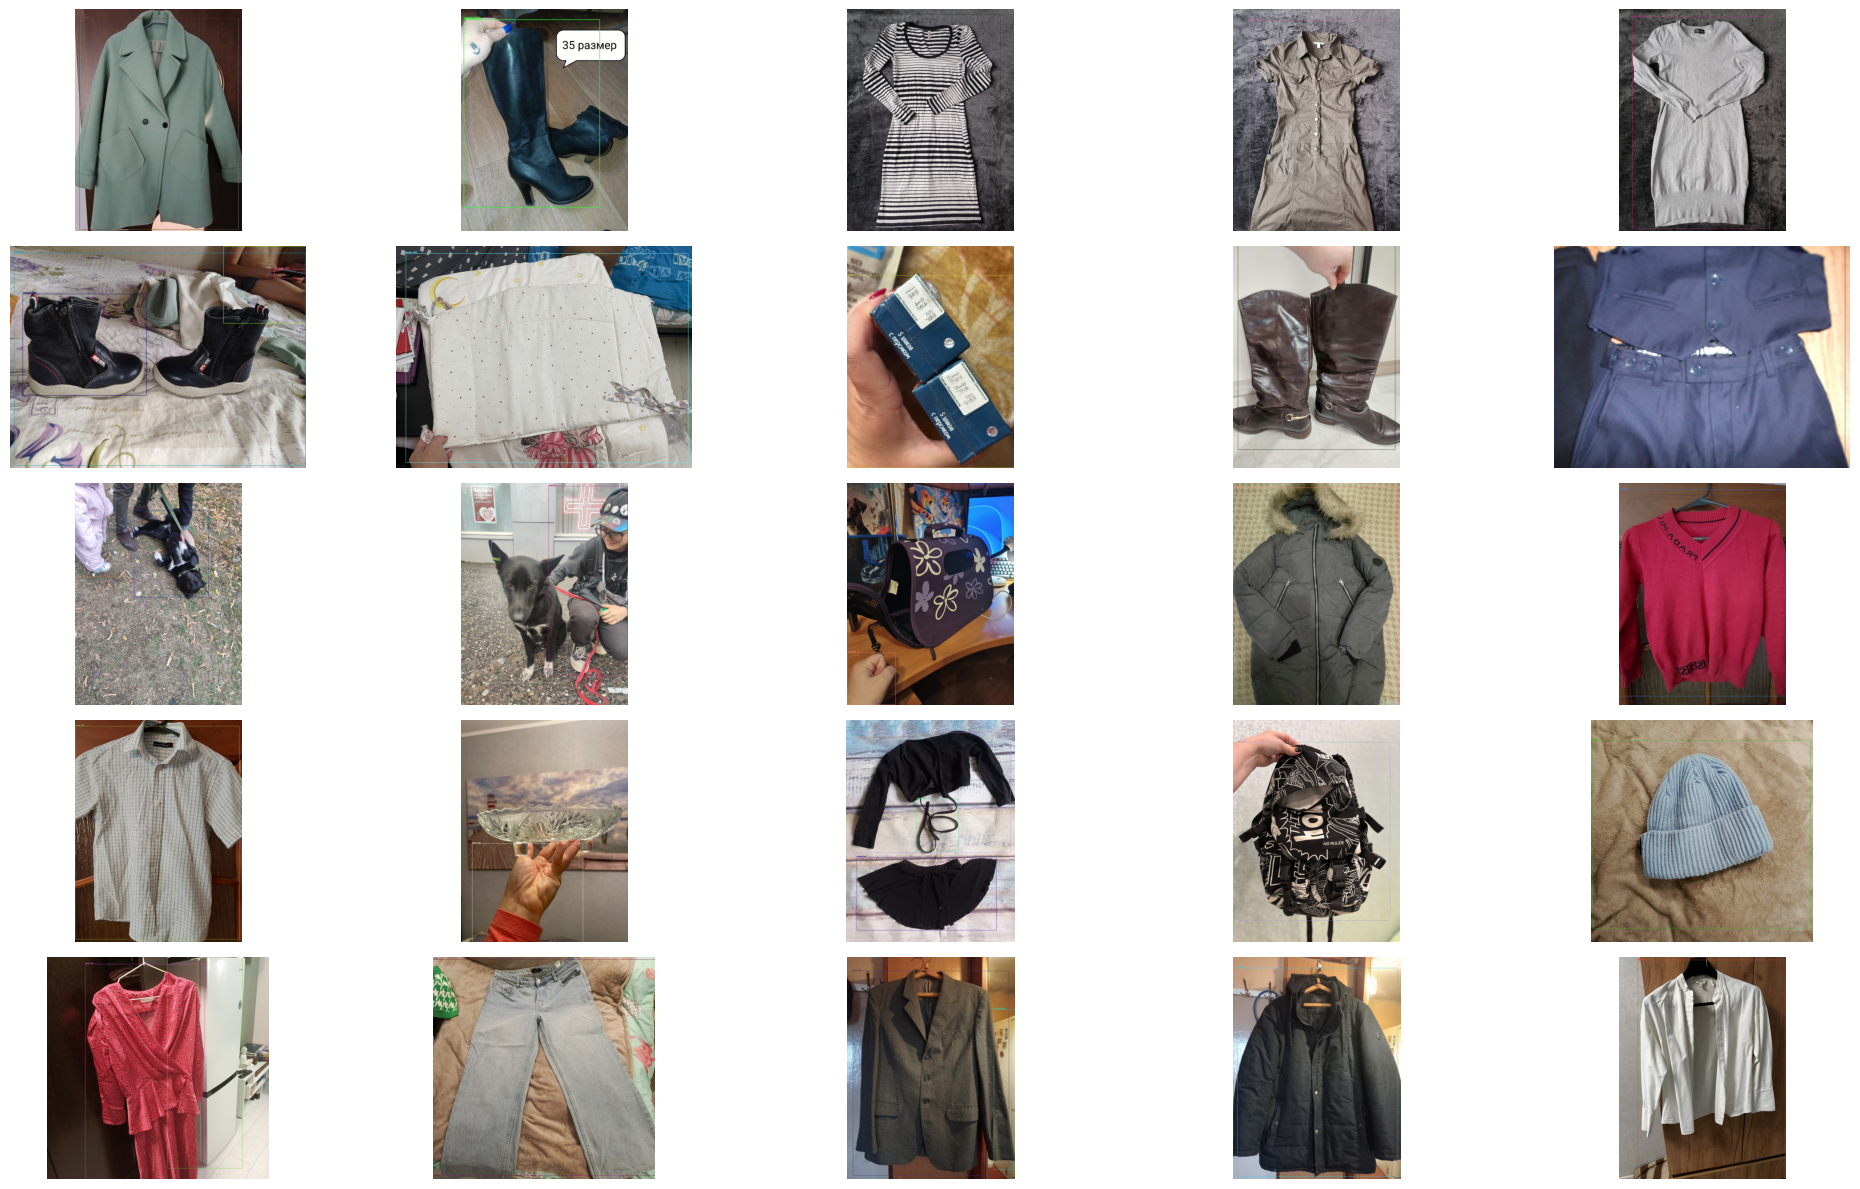

In [30]:
fig, ax = plt.subplots(5, 5, figsize=(20, 12))

for i, image_ind in enumerate(images_with_people):
    image = cv2.imread(f"results/{image_ind}.jpg")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i // 5][i % 5].imshow(image)
    ax[i // 5][i % 5].axis('off')

plt.tight_layout()
plt.show()

On some pictures YOLO found people, but in general it's just clothes that were mistaken for a preson.

#### Classes Distribution

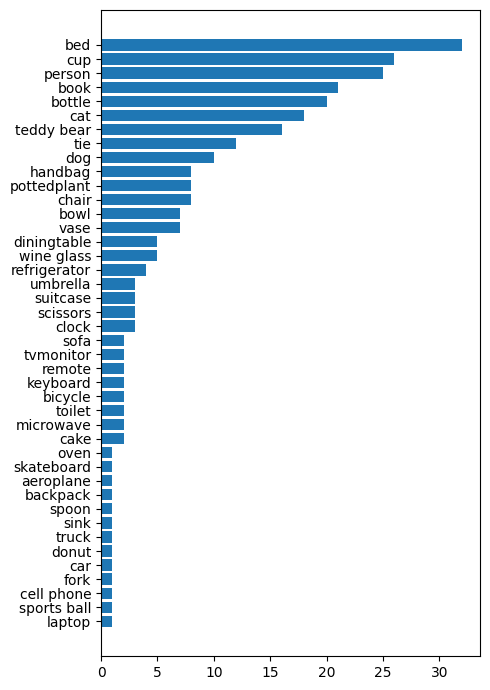

In [40]:
items = defaultdict(int)
for ind, data in meta_data.items():
    for c in data["classes"]:
        items[c] += 1

items = np.array([[k, v] for k, v in items.items()])
sort_mask = np.argsort([int(item[1]) for item in items])
items = items[sort_mask, :]

plt.figure(figsize=(5, 7))
plt.barh(items[:, 0], items[:, 1].astype(np.int64))
plt.tight_layout()
plt.show()

Let's see if people actually sell moslty beds

Number of detected beds: 32/311


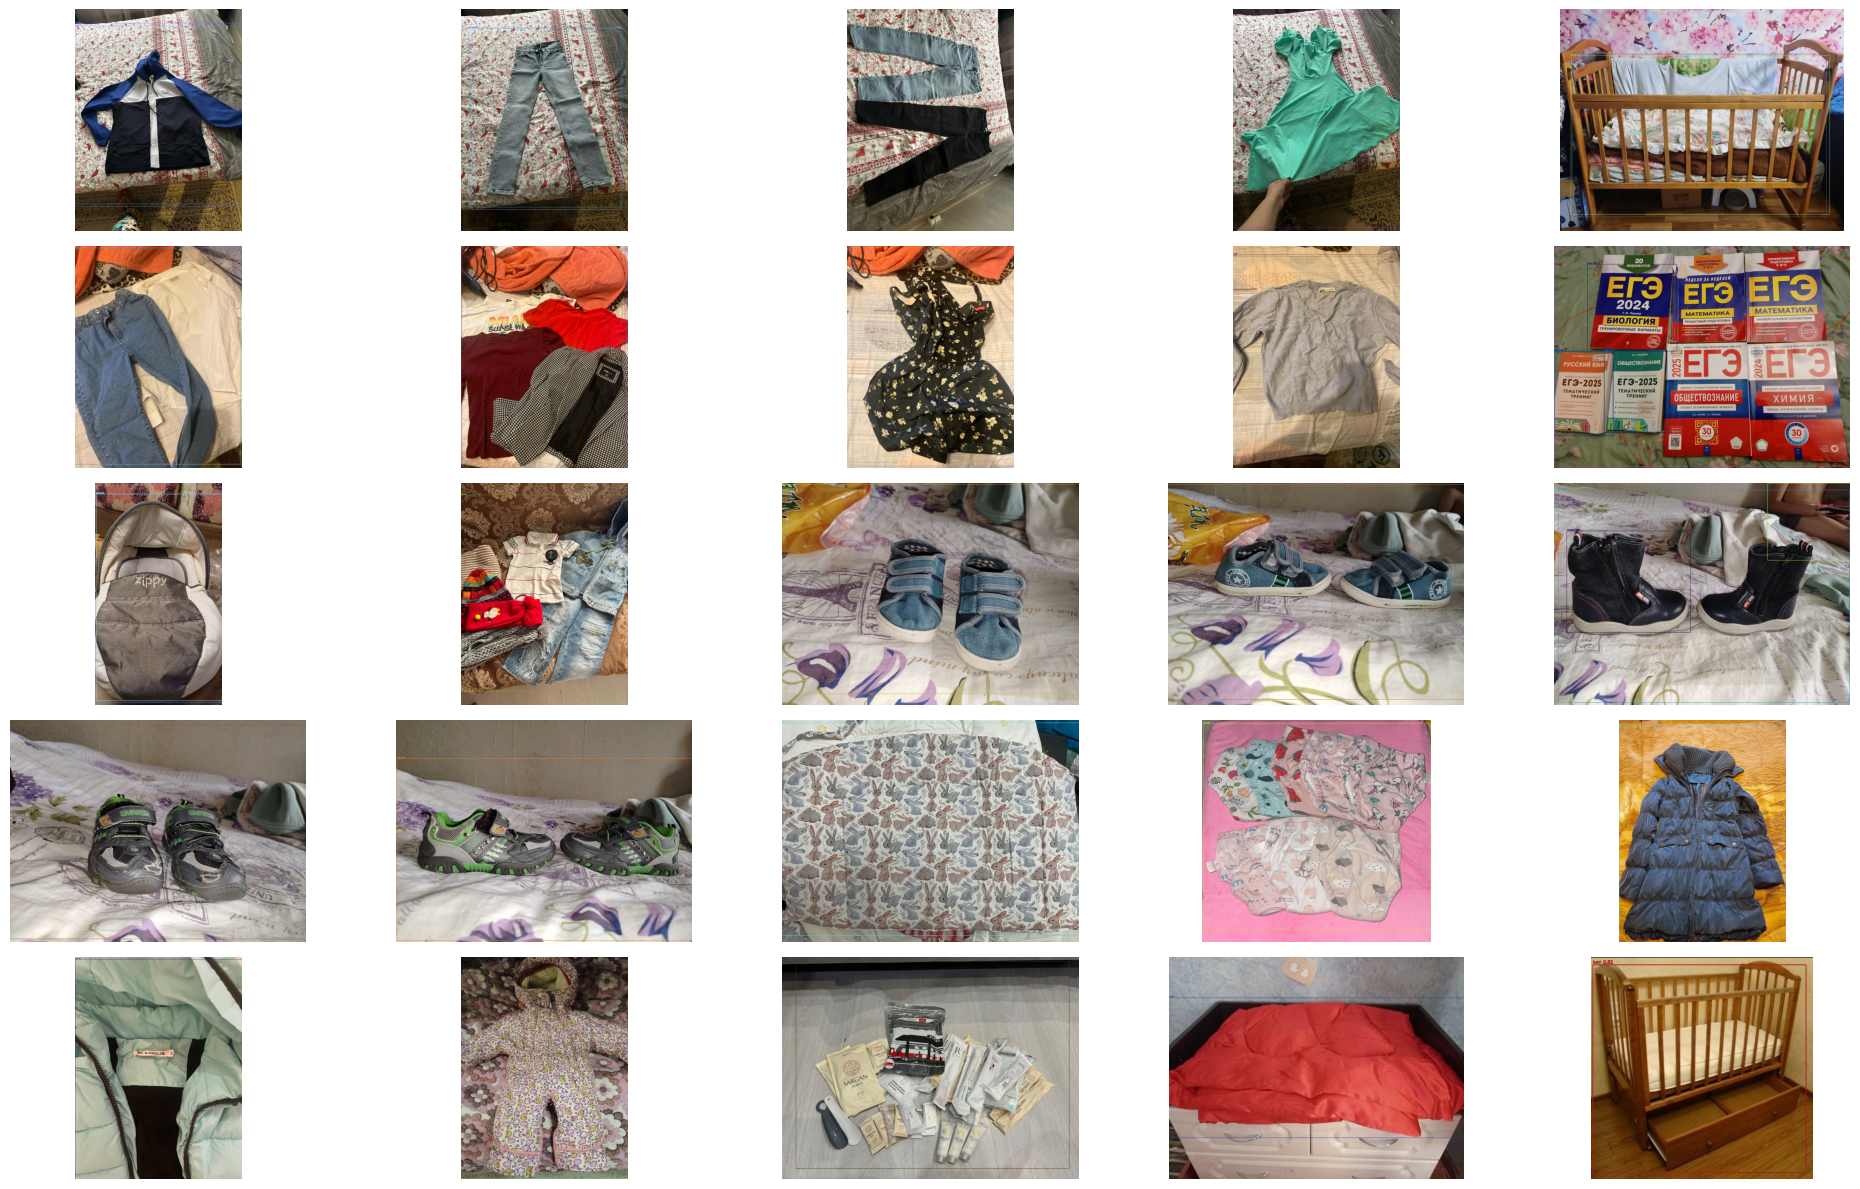

In [44]:
beds_detected_count = 0
images_with_beds = []
for ind, data in meta_data.items():
    if "bed" in data["classes"]:
        beds_detected_count += 1
        images_with_beds.append(ind)
print(f"Number of detected beds: {beds_detected_count}/{total_images}")

fig, ax = plt.subplots(5, 5, figsize=(20, 12))

for i, image_ind in enumerate(images_with_beds[:25]):
    image = cv2.imread(f"results/{image_ind}.jpg")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i // 5][i % 5].imshow(image)
    ax[i // 5][i % 5].axis('off')

plt.tight_layout()
plt.show()

As we can see, in there are only 3 beds for sell. On rest of images bed is only background and the main item is something else.

Number of detected beds: 24/311


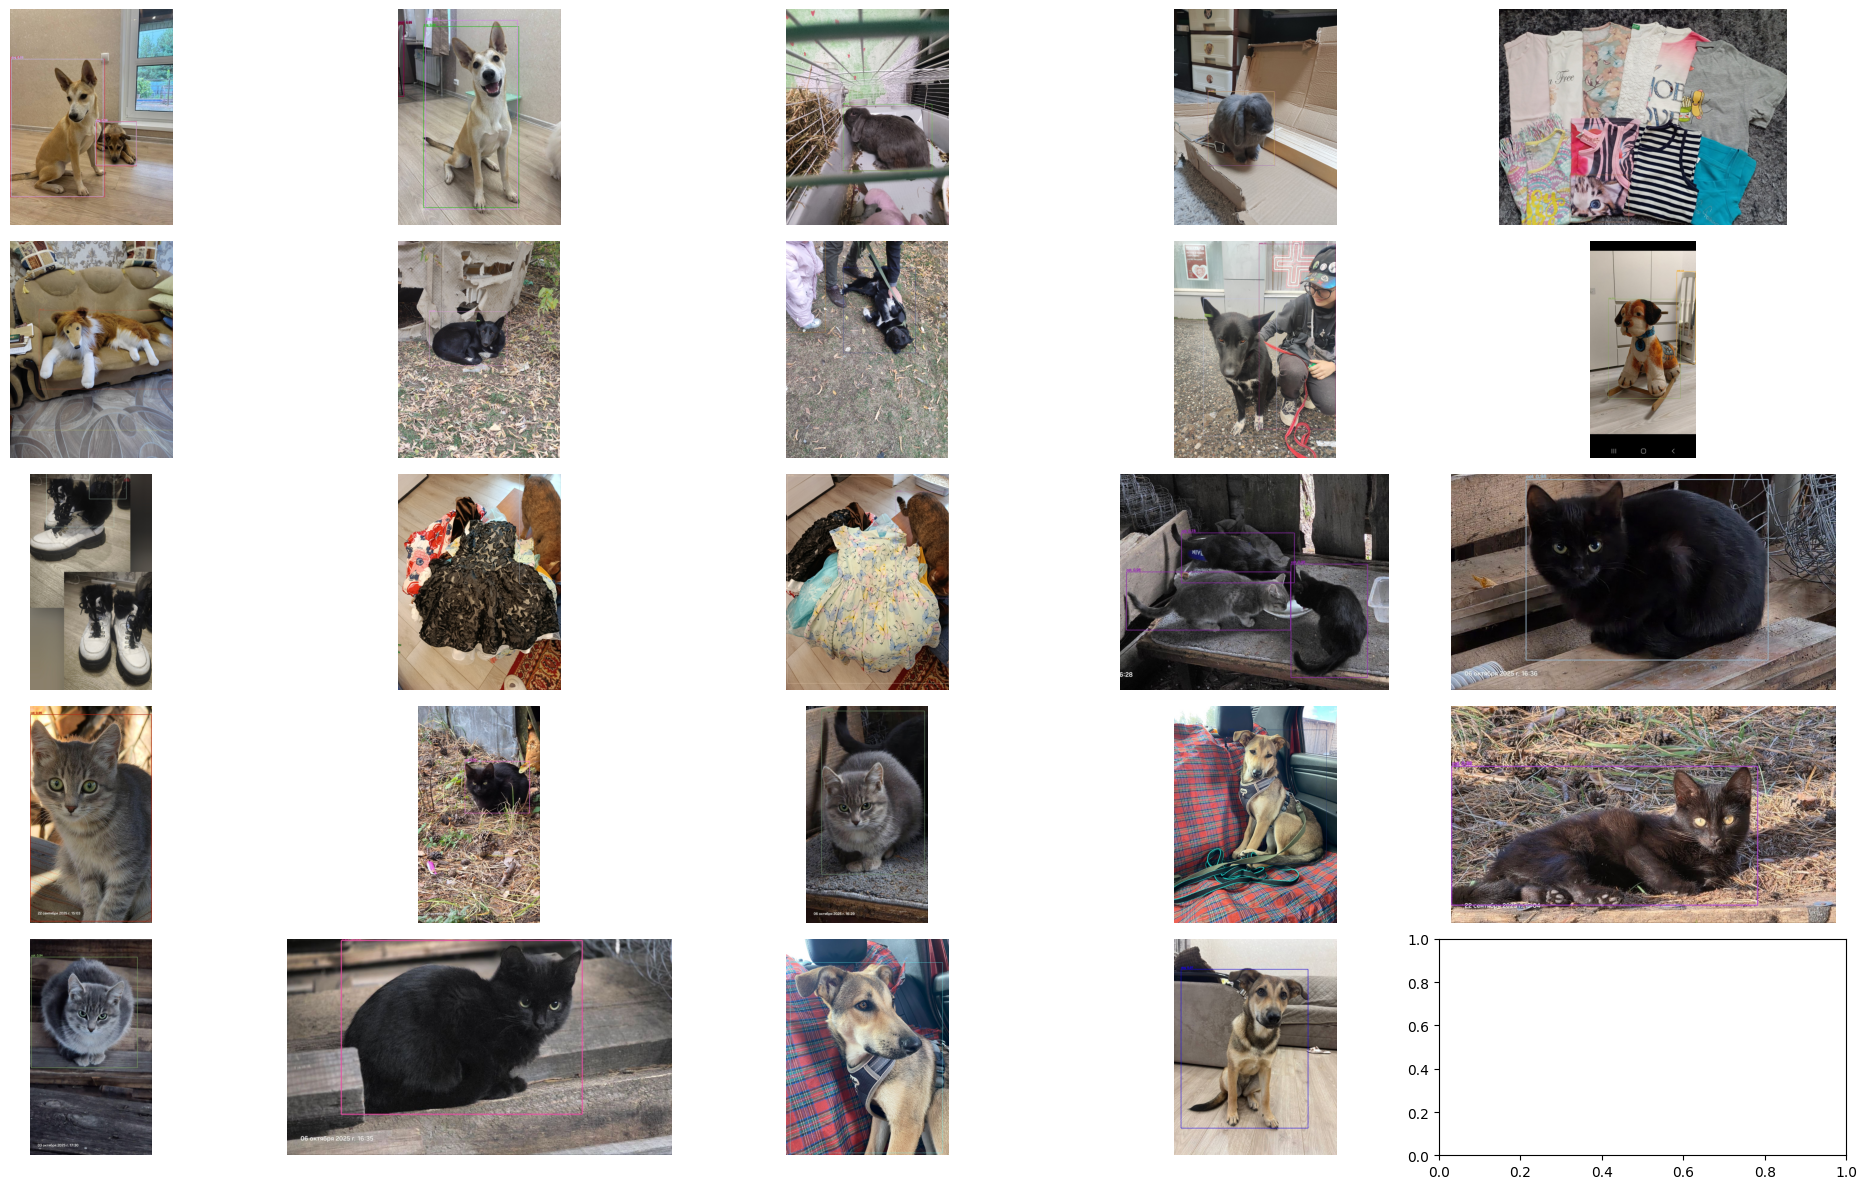

In [47]:
detected_count = 0
images_with_animals = []
for ind, data in meta_data.items():
    if "cat" in data["classes"] or "dog" in data["classes"]:
        detected_count += 1
        images_with_animals.append(ind)
print(f"Number of detected beds: {detected_count}/{total_images}")

fig, ax = plt.subplots(5, 5, figsize=(20, 12))

for i, image_ind in enumerate(images_with_animals[:25]):
    image = cv2.imread(f"results/{image_ind}.jpg")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i // 5][i % 5].imshow(image)
    ax[i // 5][i % 5].axis('off')

plt.tight_layout()
plt.show()

The good thing about YOLO is detecting cats and dogs (but it's still only less then 90% of True Positive Rate)

---

As the result, YOLO is not the best choice for this task. Model *doesn't detect any items on image in half of the cases*, has *a lot of detection mistakes* since there are few examples of COCO classes on images and *can detected background items, that are not a product for sell*. So, if we want some decent results from YOLO, we should use transfer learning on our dataset.

---